Catboost SHAP and prediction plot

1) Figure 4. Actual vs model predicted results for test day (June 9, 2018) for (a) Psychology, (b) Psychology North, and (c) ISTB 4.

2) Figure 5. Feature importance values for tuned model

3) 3 SHAP

4) Figure 9. Scenario predictions for 0.5 degree Celsius reduction in air temperature for (a) Psychology, (b) Psychology North, and (c) ISTB 4.

In [1]:
import pandas as pd
import numpy as np

# models
from sklearn.ensemble import RandomForestRegressor
# uncomment to install the three models below >>>>>
# !pip3 install catboost
from catboost import CatBoostRegressor

# processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold

# scoring
import math
from sklearn.metrics import r2_score, mean_squared_error

# viz
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure

# explain
import shap
import datetime


# import from previous notebook
import nbimporter
import Model8_four_models as FourModels

# import model
import pickle

import os

# 2. Import Data and Model

In [2]:
# required files
TRAIN_PATH = "../Data/microclimate_model/Combined/three_bldgs_dropped.csv"
TEST_PATH = "../Data/microclimate_model/Combined/three_bldgs_J9_dropped.csv"
MODEL_PATH = 'cb_best.sav'
OUTPUT_PATH = "./output/"

In [3]:
# Load data used for training
data_drop = FourModels.Data(TRAIN_PATH, TEST_PATH, isDropISTB=True)
X_train_val, y_train_val = data_drop.get_xy_trainval()
X_test, y_test= data_drop.get_xy_test()

In [4]:
# Load model
cb_name = "cb_best"
cb_best = pickle.load(open(MODEL_PATH, 'rb'))

# Confirm model
tt = FourModels.TrainTest(X_train_val, y_train_val, X_test, y_test)
tt.train_and_store_score(cb_best, cb_name)
tt.test_and_store_score(cb_best, cb_name)

# confirm correct score
scores_df = tt.get_scores_df()
print(scores_df)


model_name>>> cb_best
start time>>> 2022-11-07 17:08:39.790732
end time>>>> 2022-11-07 17:08:42.685128
dur 2.894396

test and store scores.. cb_best
{'learning_rate': 0.03, 'depth': 10, 'l2_leaf_reg': 1, 'loss_function': 'RMSE', 'verbose': False, 'n_estimators': 500, 'random_state': 42}
     model    r2_val   r2_test rmse_test mbe_test  train_time_s
0  cb_best  0.987523  0.985304  0.001089  0.00035      2.894396


# 3. Plot class

In [5]:
class Plot():
    def __init__(self, train_path, test_path):
        """
        The constructor will take the file path and create a df with only bldgname as the column.
        So we will only have the following column when plotting:
        ["bldgname", "y_pred", "y_actual" or "y_scenario_prediction"]
        """
        
        def undummify(df, prefix_sep="_"):
            """
            Inner function to undummify pandas df
            
            Return:
                undummified_df: the undummied df containing only date_time as index and bldgname column
            """
            cols2collapse = {
                item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
            }
            series_list = []
            for col, needs_to_collapse in cols2collapse.items():
                if needs_to_collapse:
                    undummified = (
                        df.filter(like=col)
                        .idxmax(axis=1)
                        .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                        .rename(col)
                    )
                    series_list.append(undummified)
                else:
                    series_list.append(df[col])
            undummified_df = pd.concat(series_list, axis=1)
            return undummified_df
        
        
        
        # create df undumify from datas that has ISTB4
        data_istb4 = FourModels.Data(train_path, test_path, isDropISTB=False)
        X_test_istb4, y_test_istb4 = data_istb4.get_xy_test()
        self.df_undum = undummify(X_test_istb4)
        
        # drop all the columns apart from bldgname with date_time as index
        cols_to_keep = ["bldgname"]
        self.df_undum = self.df_undum.drop(self.df_undum.columns.difference(cols_to_keep), 1)
        
    def plot(self, y_pred, y_actual_or_scen, 
             scene_name, 
             output_path="",
             is_scenario=False, 
             is_save=False):

        first_plot_name = "Predicted"
        if is_scenario :
            second_plot_name = "Scenario Prediction"
        else:
            second_plot_name = "Actual"
            
        # assign the column to our df
        self.df_undum[first_plot_name] = y_pred
        self.df_undum[second_plot_name] = y_actual_or_scen
        
        
        # reformat date
        df_copy = self.df_undum.copy()
        format_before = '%Y-%m-%d %H:%M:%S'
        format_after = '%H:%M'

        df_copy.index = pd.to_datetime(df_copy.index, format = format_before).strftime(format_after)
        
        # for each of the buildgname, make plot
        blist = []
        for bldgname in df_copy['bldgname'].unique():
            
            b = df_copy[df_copy['bldgname'] == bldgname]
            blist.append(b)

            # get average difference
            avg_diff = round(((b[second_plot_name].mean() - 
                            b[first_plot_name].mean())/b[first_plot_name].mean())*100,2)

            # make absolute value if its not scenario
            if not is_scenario:
                avg_diff = abs(avg_diff)

            # stringify
            avg_diff = str(avg_diff) + " %"

            # Predicted plot
            ax = b.plot(y = first_plot_name, label = first_plot_name, 
                        ylabel = 'CHWTON/SQM', title = bldgname + "    [Avg Diff:  " + avg_diff + ']')

            # second plot: Scenario or Actual
            b.plot(y = second_plot_name, label = second_plot_name, ax=ax)
            
            
            # save images
            if is_save:
                # "./output/predictions_plot/"+ scene_name + "/"
                save_path = output_path + "predictions_plot/"+ scene_name + "/"
                isExist = os.path.exists(save_path)
                if not isExist:

                   # Create a new directory because it does not exist
                   os.makedirs(save_path)
                
                fig = ax.get_figure()
                fig.savefig(save_path + bldgname +'_' + scene_name + '.png')

# 4. Scenario class

In [6]:
"""
This class encapsulates the different scenarios that will be applied to our original data.
We only want to make changes of 0.5 in Air temperature, 0.5 absolute humidity, and 0.2 in shades.
"""
class Scenario():
    def __init__(self, X_test, model):
        # model used to predict
        self.model = model
        
        # data
        self.X_test_scene = X_test.copy() # X_test has ISTB_4 to make prediction
        
        # scenarios
        self.AirTdelta = -0.5 # temperature change
        self.AbsHdelta = -0.5 # absolute humidity
        self.shadeDelta = 0.2
        
    def get_scenario_prediction(self, scenario):
        """
        Given a scenario as a string, this function will make corresponding changes to the X_test dataframe
        and then make prediction using the model initialized in constructor.
        
        Parameter:
            scenario(String) : the variable we want to change in this scenario
            
        Return:
            y_pred_scene : the prediction result
        """
        # 1. modify X_test according to new scenario
        if scenario == "Air Temp":
            self.X_test_scene[scenario] += self.AirTdelta
            
        elif scenario == "Abs Hum":
            self.X_test_scene[scenario] += self.AbsHdelta
        
        elif ("Shade" in scenario):
                print("shade scenario")
                self.X_test_scene[scenario] += self.shadeDelta
                self.X_test_scene.loc[self.X_test_scene[scenario] > 1, scenario] = 1
                
        elif (scenario == "combined"):
            self.X_test_scene["Air Temp"] += self.AirTdelta
            self.X_test_scene["Abs Hum"] += self.AbsHdelta
            
            shadcol = ['Shade East', 'Shade West', 'Shade North', 'Shade South']
            for shade_face in shadcol: 
                self.X_test_scene[shade_face] += self.shadeDelta
                self.X_test_scene.loc[self.X_test_scene[shade_face] + self.shadeDelta > 1, shade_face] = 1
        
        # 2. make prediction
        y_pred_scene = self.model.predict(self.X_test_scene)
        
        return y_pred_scene

# 5. Prediction Plot

## 5.1 Prediction VS Actual

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


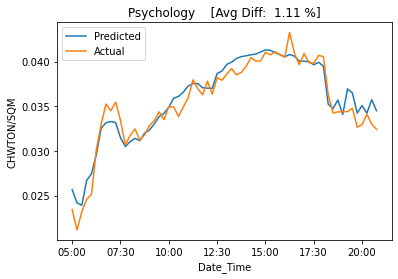

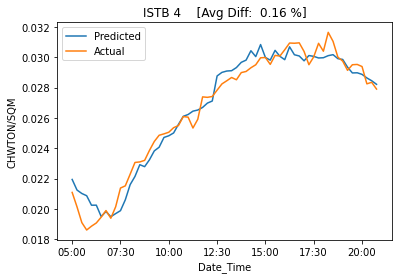

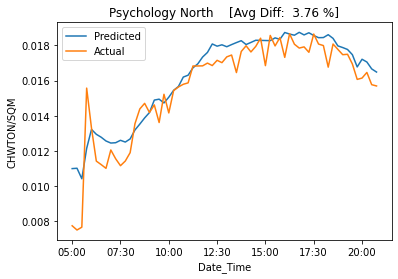

In [7]:
plt_obj = Plot(TRAIN_PATH, TEST_PATH)
y_pred = cb_best.predict(X_test)
plt_obj.plot(y_pred, y_test, 
             scene_name="actual", 
             output_path =OUTPUT_PATH, 
             is_scenario=False, 
             is_save=True)

## 5.2 Air Temp Prediction

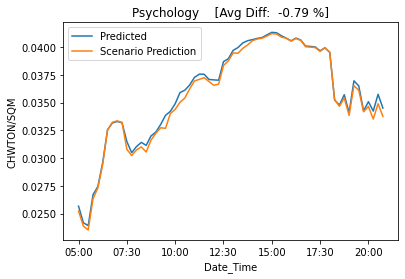

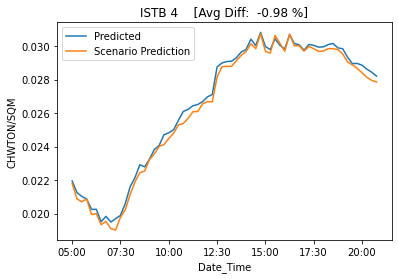

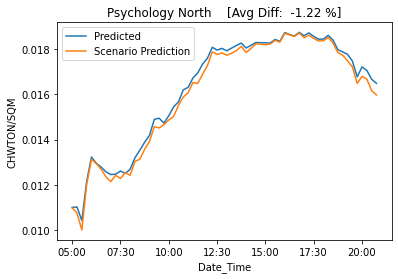

In [8]:
scenario_cb = Scenario(X_test, cb_best)
y_temp_pred = scenario_cb.get_scenario_prediction("Air Temp")
plt_obj.plot(y_pred, y_temp_pred, 
             scene_name="AirTemp", 
             output_path = OUTPUT_PATH, 
             is_scenario = True,
             is_save=True)


## 5.3 Abs Humidity Prediction

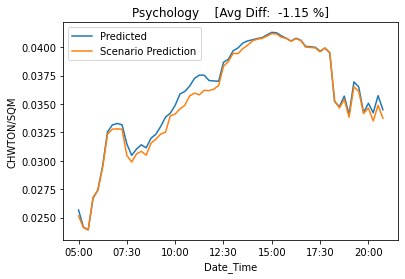

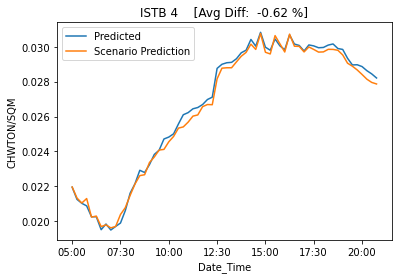

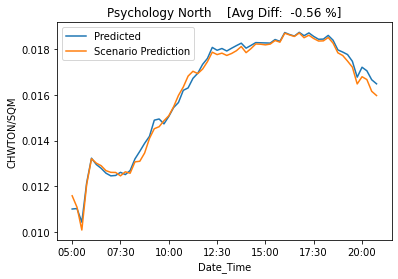

In [9]:
y_hum_pred = scenario_cb.get_scenario_prediction("Abs Hum")
plt_obj.plot(y_pred, y_hum_pred, 
             scene_name="AbsHum", 
             output_path = OUTPUT_PATH, 
             is_scenario = True,
             is_save=True)


## 5.4 Shade West Prediction

shade scenario


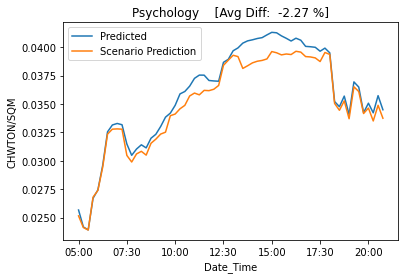

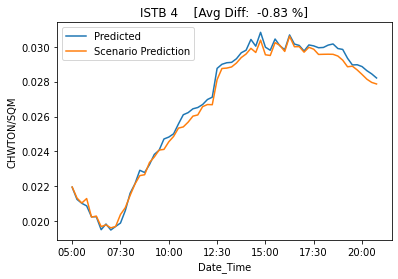

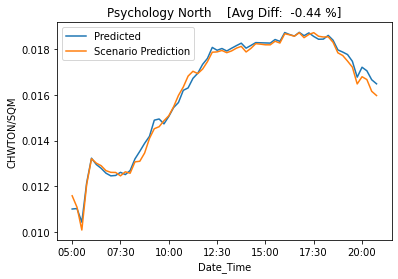

In [10]:
y_shade_west_pred = scenario_cb.get_scenario_prediction("Shade West")
plt_obj.plot(y_pred, y_shade_west_pred, 
             scene_name="ShadeWest", 
             output_path = OUTPUT_PATH, 
             is_scenario = True,
             is_save=True)

## 5.5 Shade East Prediction

shade scenario


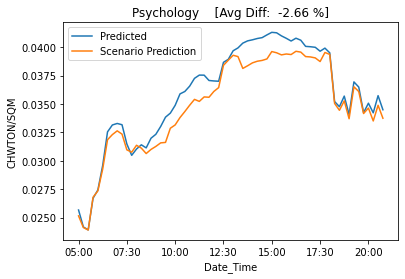

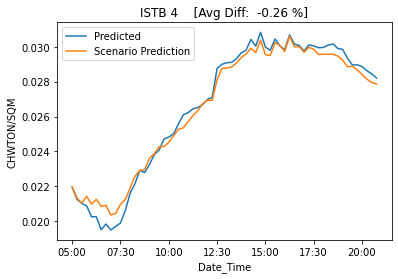

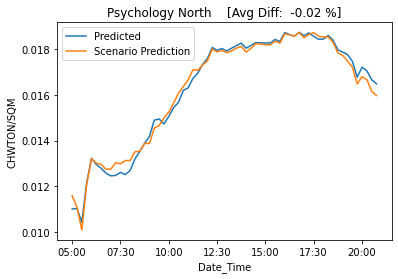

In [12]:
y_shade_east_pred = scenario_cb.get_scenario_prediction("Shade East")

plt_obj.plot(y_pred, y_shade_east_pred, 
             scene_name="ShadeEast", 
             output_path = OUTPUT_PATH, 
             is_scenario = True,
             is_save=True)

## 5.6. Combined Scenarios

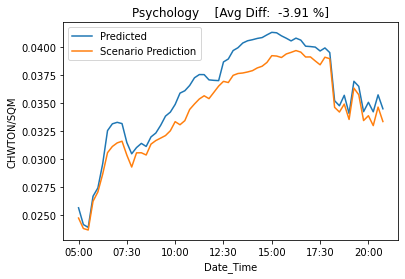

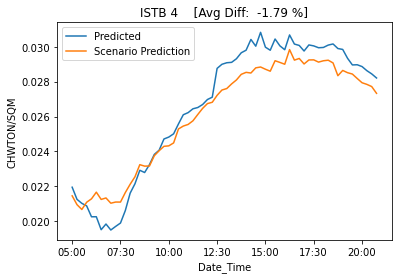

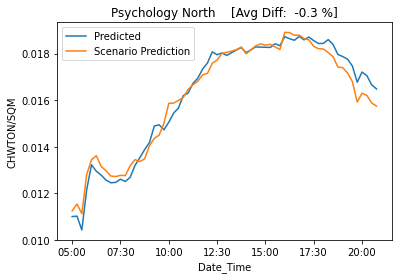

In [13]:
y_combined_pred = scenario_cb.get_scenario_prediction("combined")
plt_obj.plot(y_pred, y_combined_pred, 
             scene_name="combined", 
             output_path = OUTPUT_PATH, 
             is_scenario = True,
             is_save=True)

# 6. Feature Importance

In [14]:
cb_best.feature_importances_

array([16.32209055,  1.05708679,  1.35876088,  0.53754847,  0.71731387,
        0.29962758,  0.28793453,  0.51196012,  0.54659001,  0.34901718,
        0.37057669, 17.74289573, 17.87780054, 37.41840343,  4.60239363])

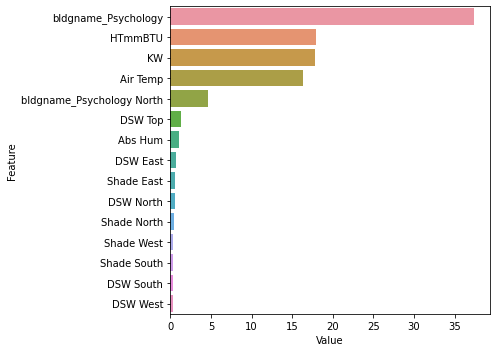

In [15]:
## Using Feature Importance
feature_imp= pd.DataFrame(sorted(zip(cb_best.get_feature_importance(), X_train_val.columns), reverse = True), columns = ['Value', 'Feature'])

plt.figure(figsize=(7,5))
sns.barplot(x='Value', y='Feature', data=feature_imp[:20].sort_values(by='Value', ascending=False))
plt.tight_layout()
plt.show()

# 7. SHAP

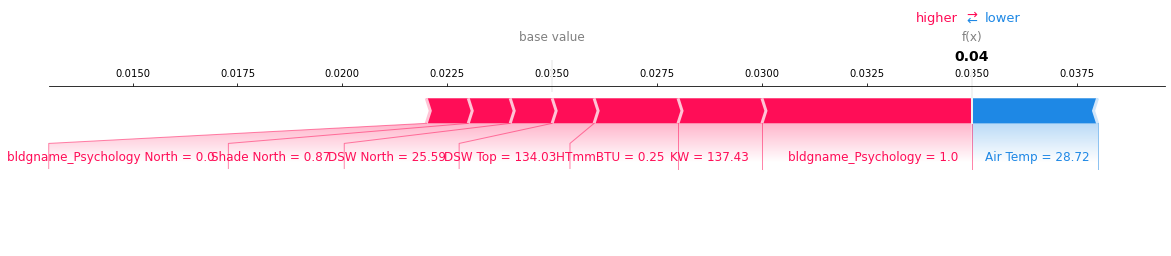

In [16]:
# 1. init explainer object
explainer = shap.TreeExplainer(model=cb_best,
                           data=None,
                           model_output='raw',
                           feature_perturbation='tree_path_dependent'
                              )

# 2. get shap values from explainer
shap_values = explainer.shap_values(X_test)

# 3. single sample plot
shap.initjs()
i = 7
shap_vals_round = np.array([np.round(x, 3) for x in shap_values[i,:]] )

shap.force_plot(round(explainer.expected_value,3), 
                shap_vals_round, 
                X_test.iloc[i,:].round(decimals = 2), matplotlib = True)

# 4. visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_test)



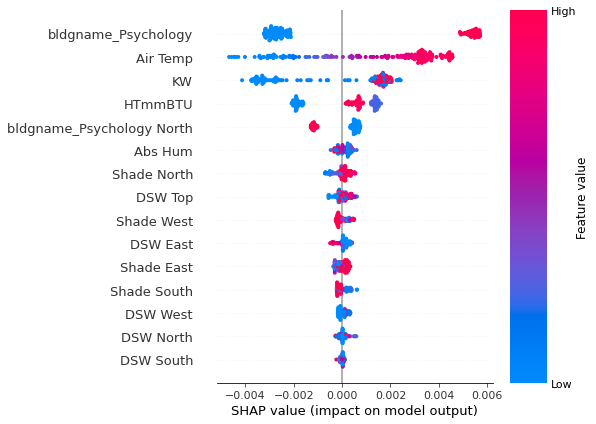

In [17]:
# 5. summary plot
# increment fig index for next plot
shap.summary_plot(shap_values, X_test, plot_size = [8,6], show = False)
plt.gcf().axes[-1].set_aspect(10)
plt.gcf().axes[-1].set_box_aspect(10)